In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [10]:
# Load stock data
company = "FB"
start = dt.date(2012, 1, 1)
end = dt.date.today()

data = web.DataReader(company, "yahoo", start, end)
data


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2022-03-23,216.800003,212.160004,213.330002,213.460007,23717300,213.460007
2022-03-24,220.669998,214.789993,215.000000,219.570007,31502300,219.570007
2022-03-25,225.500000,218.889999,220.509995,221.820007,40010500,221.820007


In [11]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

prediction_days = 60
future_day = 30

X_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    X_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [12]:
# Build the Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # prevent overfitting
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # prediction of the next closing value

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=25, batch_size=32)

# model.save()

Epoch 1/25
75/75 [==============================] - 4s 34ms/step - loss: 0.0179
Epoch 2/25
75/75 [==============================] - 3s 38ms/step - loss: 0.0055
Epoch 3/25
75/75 [==============================] - 3s 36ms/step - loss: 0.0060
Epoch 4/25
75/75 [==============================] - 3s 36ms/step - loss: 0.0055
Epoch 5/25
75/75 [==============================] - 3s 36ms/step - loss: 0.0052
Epoch 6/25
75/75 [==============================] - 3s 37ms/step - loss: 0.0058
Epoch 7/25
75/75 [==============================] - 3s 37ms/step - loss: 0.0052
Epoch 8/25
75/75 [==============================] - 3s 36ms/step - loss: 0.0047
Epoch 9/25
75/75 [==============================] - 3s 36ms/step - loss: 0.0055
Epoch 10/25
75/75 [==============================] - 3s 36ms/step - loss: 0.0049
Epoch 11/25
75/75 [==============================] - 3s 36ms/step - loss: 0.0047
Epoch 12/25
75/75 [==============================] - 3s 38ms/step - loss: 0.0047
Epoch 13/25
75/75 [==================

In [13]:
# Test the model accuracy on existing data
# Load Test Data
test_start = dt.date(2020, 1, 1) + dt.timedelta(days=-prediction_days)
test_end = dt.date.today()

test_data = web.DataReader(company, "yahoo", test_start, test_end)
actual_prices = test_data["Close"].values

total_dataset = pd.concat((data["Close"], test_data["Close"]), axis=0)

model_inputs = total_dataset[
    len(total_dataset) - len(test_data) - prediction_days :
].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


In [14]:
# Make Predictions on Test Data
X_test = []

for x in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x - prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


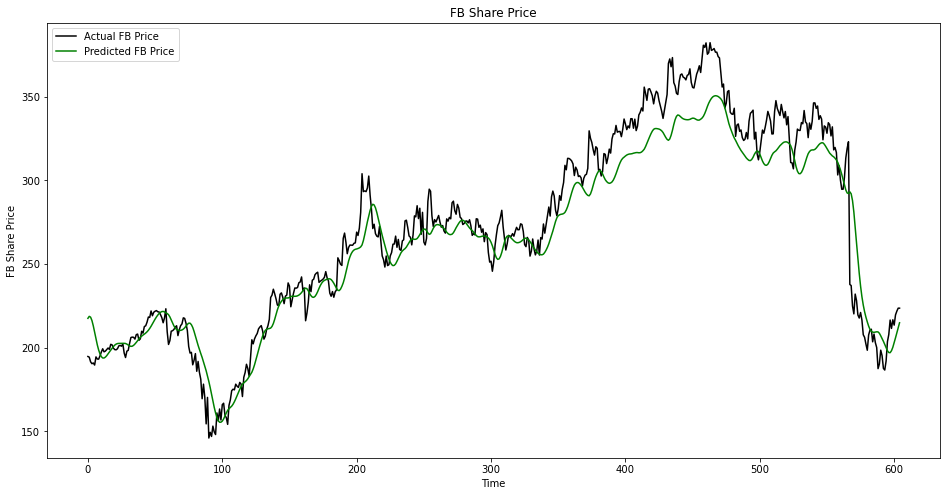

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot the test predictions
plt.figure(figsize=(16,8))
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend(loc='upper left')
plt.show()
# plt.savefig(f"./plot/{company}_Predicted_Price.png")

In [ ]:
# Predict Next Day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
# print(scaler.inverse_transform(real_data[-1]))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniconda/base/envs/trading_env/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 60, 1), found shape=(None, 59, 1)
